In [80]:
import statsmodels.api as sm
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices                   # https://pypi.python.org/pypi/patsy
#from statsmodels.sandbox.regression.predstd import wls_prediction_std

#%matplotlib inline
%matplotlib notebook

auto_data_file = "data/Auto.data"
carseats_data_file = "data/Carseats.data"

#EX. 8 Auto Dataset

In [74]:
data = pd.read_csv(auto_data_file,index_col=8,na_values='?')
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18,8,307,130,3504,12.0,70,1
buick skylark 320,15,8,350,165,3693,11.5,70,1
plymouth satellite,18,8,318,150,3436,11.0,70,1
amc rebel sst,16,8,304,150,3433,12.0,70,1
ford torino,17,8,302,140,3449,10.5,70,1


### 8.a) Use the lm() function to perform a simple linear regression with mpg as the response and horsepower as the predictor. Use the summary() function to print the results. Comment on the output. For example:
##### i. Is there a relationship between the predictor and the response?
Yes. p-value very small, t-stats very distant from 0)
##### ii. How strong is the relationship between the predictor and the response?
The relationship is strong. Predictor coefficient does not cross zero in the confidence interval.
#####.iii. Is the relationship between the predictor and the response positive or negative?
Predictor and response are negatively correlated (negative coefficient)
##### iv. What is the predicted mpg associated with a horsepower of 98? What are the associated 95% confidence and prediction intervals?
Predicted mpg associated with a horsepower of 98? What are the associated 95% confidence and prediction intervals?

In [75]:
y,x = dmatrices('mpg ~ horsepower',data=data,return_type='dataframe')
model = sm.OLS(endog=y,exog=x)
result = model.fit() 
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Sat, 27 Feb 2016   Prob (F-statistic):           7.03e-81
Time:                        13:48:11   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     39.9359      0.717     55.660      0.000        38.525    41.347
horsepower    -0.1578      0.006    -24.489      0.000        -0.171    -0.145
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [76]:
test_hp = result.params.copy()
test_hp['Intercept'] = 1
test_hp['horsepower'] = 98

# Confidence interval of the fitted params -- R: confint (lm.fit)
# There is a method in statsmodels.sandbox.regression.predstd, but it is unclear and not exactly what we need.
confint = result.conf_int()
ymin = confint[0]['Intercept'] + confint[0]['horsepower'] * test_hp['horsepower']
ymax = confint[1]['Intercept'] + confint[1]['horsepower'] * test_hp['horsepower']

print 'Predicted mpg for horsepower of '+str(test_hp['horsepower'])+': '+str(result.predict(test_hp)[0])+ ' mpg'
print 'Confidence interval for mpg: ['+str(ymin)+','+str(ymax)+']'
print confint

Predicted mpg for horsepower of 98.0: 24.4670771525 mpg
Confidence interval for mpg: [21.8145449597,27.1196093453]
                    0          1
Intercept   38.525212  41.346510
horsepower  -0.170517  -0.145172


#### 8.b) Plot the response and the predictor. Use the abline() function to display the least squares regression line.

<IPython.core.display.Javascript object>


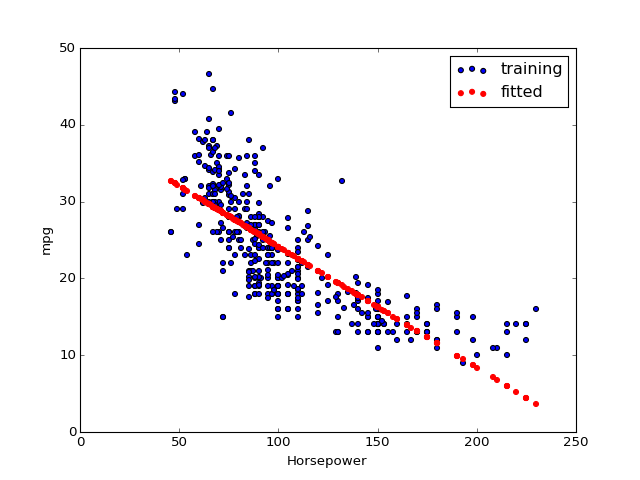

In [77]:
plt.figure()
plt.scatter(data['horsepower'],data['mpg'],label='training')
plt.scatter(data['horsepower'].dropna(),result.fittedvalues,color='r',label='fitted')

plt.xlim([0,250])
plt.xlabel('Horsepower')
plt.ylabel('mpg')
plt.legend()

### 8.c) Use the plot() function to produce diagnostic plots of the least squares regression fit. Comment on any problems you see with the fit.
- Residuals have a U-shape - that indicates non linearities in the relationship mpg/horsepower.
- Reflected in the other graphs. E.g. variance is non constant.
- There are some outliers in the data (bottom-right graph, STUD_RESID > 3). We should look for high leverage points and see if they may cause a problem
- Interestingly, it is not the points with high studentised residuals that cause problems. Other points have high leverage instead

<IPython.core.display.Javascript object>


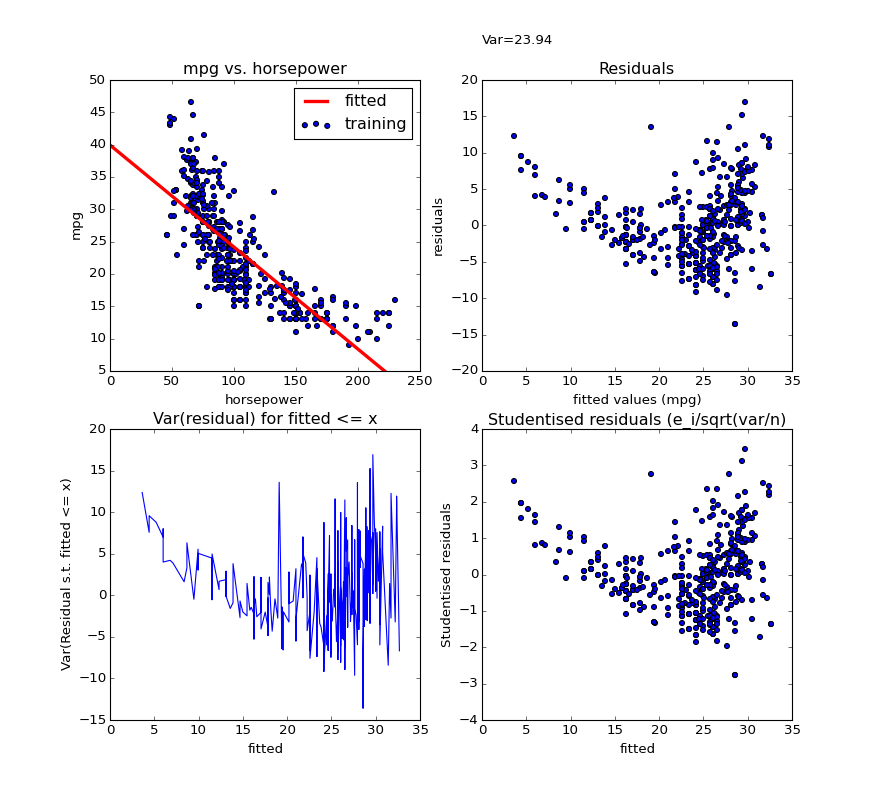

<IPython.core.display.Javascript object>


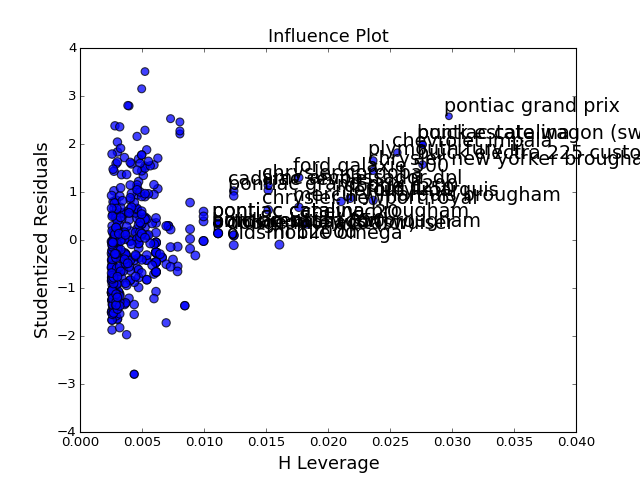

(0, 0.04)

In [6]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(11,10,forward=True)

# (1) mpg vs. horsepower
ax[0,0].scatter(data['horsepower'],data['mpg'])
sm.graphics.abline_plot(model_results=result,ax=ax[0,0],color='r',linewidth=3)
ax[0,0].set_xlabel('horsepower')
ax[0,0].set_ylabel('mpg')
ax[0,0].set_title('mpg vs. horsepower')
ax[0,0].legend(['fitted','training'])

# (2) RESIDUALS
ax[0,1].scatter(result.fittedvalues,result.resid)
ax[0,1].set_xlabel('fitted values (mpg)')
ax[0,1].set_ylabel('residuals')
ax[0,1].set_title('Residuals')
ax[0,1].text(0,25,'Var=%3.2f' % (np.var(result.resid)))

# (3) CUMULATIVE VARIANCE AS A FUNCTION OF LSTAT
residuals=pd.DataFrame({'fitted':result.fittedvalues,'resid':result.resid})
residuals_sort=residuals.sort(columns='fitted')
residuals_sort.reset_index(inplace=True)
residuals_sort['var_incr'] = np.nan
for i in residuals_sort.index:
    residuals_sort.loc[i,'var_incr'] = np.var(residuals_sort.iloc[0:i]['resid'])
ax[1,0].plot(residuals_sort['fitted'],residuals_sort['resid'])
ax[1,0].set_xlabel('fitted')
ax[1,0].set_ylabel('Var(Residual s.t. fitted <= x)')
ax[1,0].set_title('Var(residual) for fitted <= x')

# (4) Outliers, STUDENTIZED RESIDUALS 
# e_i / STD_ERR <-- e_i / sqrt(var/n)
# 
residuals['studentised']=result.get_influence().get_resid_studentized_external()
ax[1,1].scatter(residuals['fitted'],residuals['studentised'])
ax[1,1].set_xlabel('fitted')
ax[1,1].set_ylabel('Studentised residuals')
ax[1,1].set_title('Studentised residuals (e_i/sqrt(var/n)')


p=sm.graphics.influence_plot(result,size=6,alpha=1)
infl = result.get_influence()
response = infl.summary_frame()
response.head()
p.axes[0].set_xlim([0,0.04])

# Ex 9. Multiple linear regression on the Auto data set.
### 9.a) Produce a scatterplot matrix which includes all of the variables in the data set.
### 9.b) Compute the matrix of correlations between the variables using the function cor(). You will need to exclude the name variable, which is qualitative.
- strong negative correlation between MPG and CYLINDERS, DISPLACEMENT, HORSEPOWER, WEIGHT
- notice that these 4 variables are all correlated with each other
- mmoderate positive correlation between MPG and YEAR, ORIGIN
- weak correlation between MPG and ACCELERATION

<IPython.core.display.Javascript object>


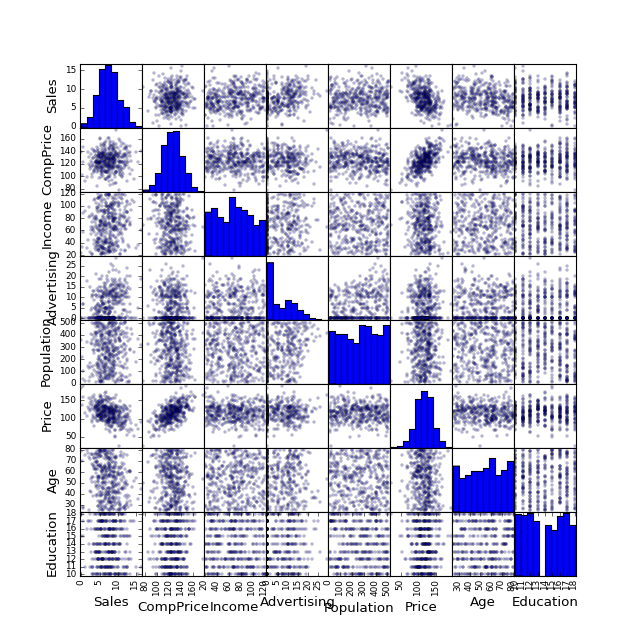

In [108]:
# Summary stats of the data
# print data.describe() - check that there are columns with nominal values (name is the index)

# Scatterplot matrix
axes = pd.tools.plotting.scatter_matrix(data,alpha=0.2,figsize=(8,8))

<IPython.core.display.Javascript object>


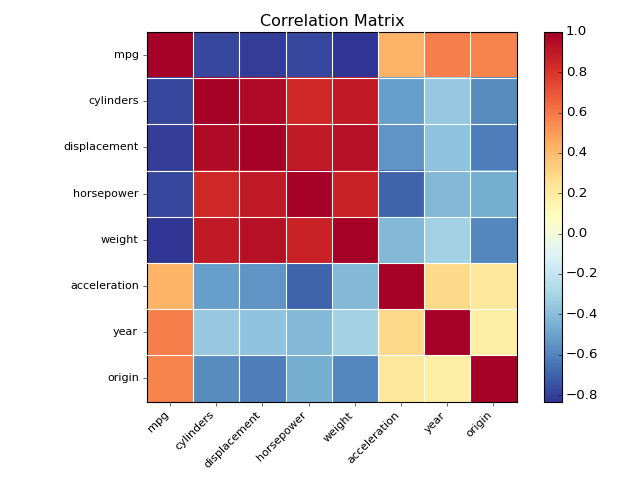

In [8]:
# Correlation matrix
corr_matrix = np.corrcoef(data.dropna(),rowvar=0)
f=sm.graphics.plot_corr(corr_matrix,xnames=list(data.columns))

### 9.c) Use the lm() function to perform a multiple linear regression with mpg as the response and all other variables except name as the predictors. Use the summary() function to print the results. Comment on the output. For instance:
##### i. Is there a relationship between the predictors and the response?
##### ii. Which predictors appear to have a statistically significant relationship to the response?
##### iii. What does the coefficient for the year variable suggest?
- The statistically significant predictors are ORIGIN, WEIGHT, YEAR
- As expected only one between CYLINDERS, DISPLACEMENT, HORSEPOWER, WEIGHT is a strong predictor
- Slightly surprisingly, this is not HORSEPOWER
- DISPLACEMENT seems to be marginally significant. But it's a false impression. Fit a linear regression on ORIGIN, WEIGHT, YEAR, DISPLACEMENT and you will find that this variable is not significant
- The coefficient for YEAR suggest a strong relationship - the newer the car, the faster it goes

In [9]:
formula = 'mpg ~ ' + ' + '.join(data.columns.difference(['mpg']))
y2,x2 = dmatrices(formula ,data=data,return_type='dataframe')
model2 = sm.OLS(endog=y2,exog=x2)
result2 = model2.fit() 
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     252.4
Date:                Sat, 27 Feb 2016   Prob (F-statistic):          2.04e-139
Time:                        12:48:33   Log-Likelihood:                -1023.5
No. Observations:                 392   AIC:                             2063.
Df Residuals:                     384   BIC:                             2095.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept      -17.2184      4.644     -3.707      0.000       -26.350    -8.087
acceleration     0.0806      0.099      0.815      0.415        -0.114     0.275
cylinders       -0.4934      0.323     -1.526      0.128        -1.129     0.142
displacement     0.0199      0.008      2.647      0.008         0.005     0.035
horsepower      -0.0170      0.014     -1.230      0.220        -0.044     0.010
origin           1.4261      0.278      5.127      0.000         0.879     1.973
weight          -0.0065      0.001     -9.929      0.000        -0.008    -0.005
year             0.7508      0.051     14.729      0.000         0.651     0.851
==============================================================================
Omnibus:                       31.906   Durbin-Watson:                   1.309
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.100
Skew:                           0.529   Prob(JB):                     2.95e-12
Kurtosis:                       4.460   Cond. No.                     8.59e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.59e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 9.d) Use the plot() function to produce diagnostic plots of the linear regression fit. Comment on any problems you see with the fit. Do the residual plots suggest any unusually large outliers? Does the leverage plot identify any observations with unusually high leverage?

<IPython.core.display.Javascript object>


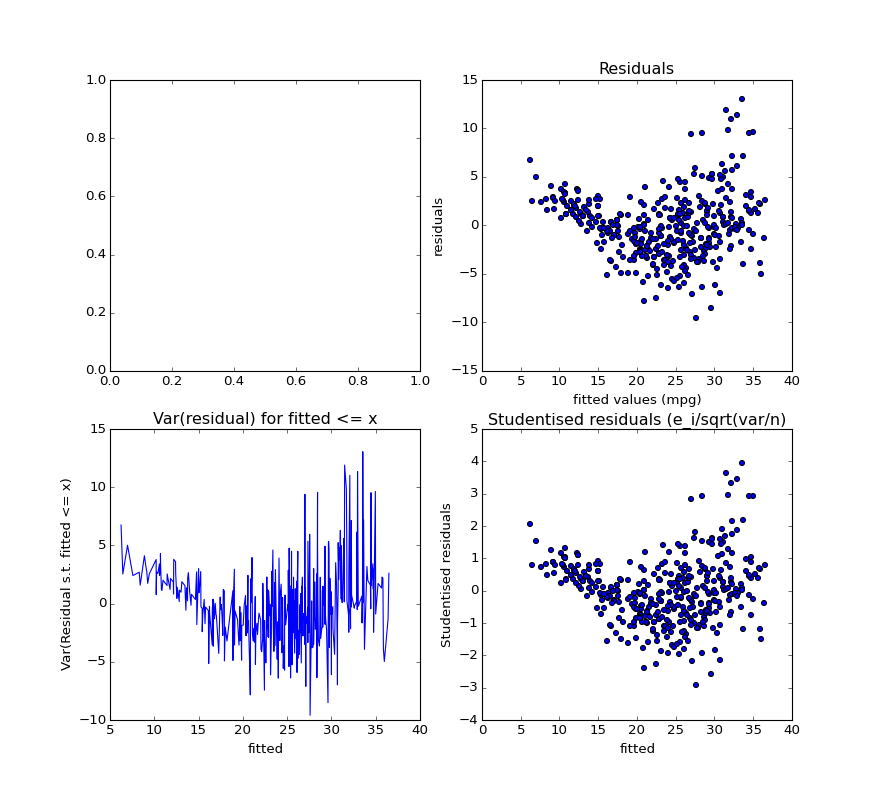

<IPython.core.display.Javascript object>


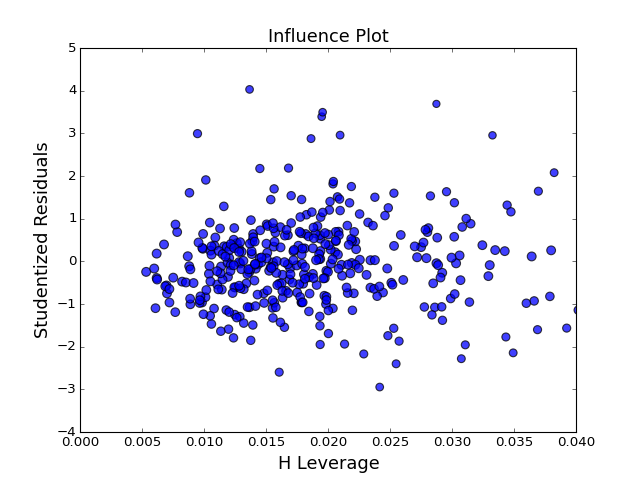

(0, 0.04)

In [92]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(11,10,forward=True)

# (1) mpg vs. horsepower

# (2) RESIDUALS
ax[0,1].scatter(result2.fittedvalues,result2.resid)
ax[0,1].set_xlabel('fitted values (mpg)')
ax[0,1].set_ylabel('residuals')
ax[0,1].set_title('Residuals')
ax[0,1].text(0,25,'Var=%3.2f' % (np.var(result2.resid)))

# (3) CUMULATIVE VARIANCE AS A FUNCTION OF LSTAT
residuals=pd.DataFrame({'fitted':result2.fittedvalues,'resid':result2.resid})
residuals_sort=residuals.sort(columns='fitted')
residuals_sort.reset_index(inplace=True)
residuals_sort['var_incr'] = np.nan
for i in residuals_sort.index:
    residuals_sort.loc[i,'var_incr'] = np.var(residuals_sort.iloc[0:i]['resid'])
ax[1,0].plot(residuals_sort['fitted'],residuals_sort['resid'])
ax[1,0].set_xlabel('fitted')
ax[1,0].set_ylabel('Var(Residual s.t. fitted <= x)')
ax[1,0].set_title('Var(residual) for fitted <= x')

# (4) Outliers, STUDENTIZED RESIDUALS 
# e_i / STD_ERR <-- e_i / sqrt(var/n)
# 
residuals['studentised']=result2.get_influence().get_resid_studentized_external()
ax[1,1].scatter(residuals['fitted'],residuals['studentised'])
ax[1,1].set_xlabel('fitted')
ax[1,1].set_ylabel('Studentised residuals')
ax[1,1].set_title('Studentised residuals (e_i/sqrt(var/n)')

# High Leverage, STUDENTISED RESIDUALS VS. LEVERAGE
p=sm.graphics.influence_plot(result2,size=6,alpha=1)
infl = result2.get_influence()
response = infl.summary_frame()
p.axes[0].set_xlim([0,0.04])

### 9.e) Use the * and : symbols to fit linear regression models with interaction effects. Do any interactions appear to be statistically significant?
- The interaction ORIGIN:YEAR is definitely not significant - removed
- The other two interaction have small p-value, but their coefficients are so small that it is questionable weather they are truly significant - removed

In [19]:
#formula = 'mpg ~ origin + weight + year + origin:weight + origin:year + weight:year'
formula = 'mpg ~ origin + weight + year + origin:weight + weight:year'
y3,x3 = dmatrices(formula ,data=data,return_type='dataframe')
model3 = sm.OLS(endog=y3,exog=x3)
result3 = model3.fit() 
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     426.3
Date:                Sat, 27 Feb 2016   Prob (F-statistic):          8.41e-156
Time:                        12:58:55   Log-Likelihood:                -1009.6
No. Observations:                 397   AIC:                             2031.
Df Residuals:                     391   BIC:                             2055.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept      -105.0705     12.551     -8.371      0.000      -129.747   -80.394
origin            4.4228      1.139      3.884      0.000         2.184     6.661
weight            0.0248      0.004      5.755      0.000         0.016     0.033
year              1.8724      0.171     10.981      0.000         1.537     2.208
origin:weight    -0.0015      0.000     -3.159      0.002        -0.002    -0.001
weight:year      -0.0004   5.94e-05     -6.599      0.000        -0.001    -0.000
==============================================================================
Omnibus:                       48.545   Durbin-Watson:                   1.406
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.761
Skew:                           0.666   Prob(JB):                     8.00e-23
Kurtosis:                       5.092   Cond. No.                     1.88e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.88e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 9.f) Transformations of the variables, e.g. log(X), sqrt(X), X^2. Comment on your findings
- There are non-linear dependencies - although we are probably overfitting

In [78]:
v = ['origin','weight','year']
sqrt = []
for el in v: sqrt.append('np.sqrt('+el+')')

log = []
for el in v: log.append('np.log('+el+')')

sq = []
for el in v: sq.append('np.power('+el+',2)')
    
cub = []
for el in v: cub.append('np.power('+el+',3)')

## STARTING FORMULA - I WILL REMOVE ONE PARAM AT A TIME
starting_formula = 'mpg ~ ' + ' + '.join(v)\
            + ' + ' + ' + '.join(sqrt)\
            + ' + ' + ' + '.join(log)\
            + ' + ' + ' + '.join(sq)\
            + ' + ' + ' + '.join(cub)

formula = 'mpg ~ origin + weight + year +\
            + np.power(origin,2)+ np.power(weight,2) + np.power(year,2)\
            + np.power(origin,3) + np.power(year,3)'
y4,x4 = dmatrices(formula ,data=data,return_type='dataframe')
model4 = sm.OLS(endog=y4,exog=x4)
result4 = model4.fit() 
result4.summary()

#sorted_pvalues=result4.pvalues
#sorted_pvalues.sort(ascending=False)
#print sorted_pvalues

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     371.7
Date:                Sat, 27 Feb 2016   Prob (F-statistic):          5.87e-168
Time:                        13:49:49   Log-Likelihood:                -974.74
No. Observations:                 397   AIC:                             1965.
Df Residuals:                     389   BIC:                             1997.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept            4732.0980   1284.071      3.685      0.000      2207.509  7256.687
origin               1977.4160    536.375      3.687      0.000       922.858  3031.974
weight                 -0.0205      0.001    -14.101      0.000        -0.023    -0.018
year                 -224.2909     62.373     -3.596      0.000      -346.922  -101.660
np.power(origin, 2) -1076.9525    292.589     -3.681      0.000     -1652.206  -501.699
np.power(weight, 2)  2.261e-06    2.2e-07     10.267      0.000      1.83e-06  2.69e-06
np.power(year, 2)       2.9004      0.822      3.530      0.000         1.285     4.516
np.power(origin, 3)   179.2971     48.767      3.677      0.000        83.417   275.178
np.power(year, 3)      -0.0124      0.004     -3.450      0.001        -0.020    -0.005
==============================================================================
Omnibus:                       45.086   Durbin-Watson:                   1.499
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              117.560
Skew:                           0.548   Prob(JB):                     2.97e-26
Kurtosis:                       5.430   Cond. No.                     4.43e+21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.44e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## 10. This question should be answered using the Carseats data set.
### 10.a) Fit a multiple regression model to predict Sales using Price, Urban, and US.
### 10.b) Provide an interpretation of each coefficient in the model. Be careful—some of the variables in the model are qualitative!
### 10.c) Write out the model in equation form, being careful to handle the qualitative variables properly.
- Urban=Yes, US=Yes -->  Sales = B0 + B1 + B2 + B3 * Price
- Urban=Yes, US=No -->  Sales = B0 + B1 + B3 * Price
- Urban=No, US=Yes -->  Sales = B0 + B2 + B3 * Price
- Urban=No, US=No -->  Sales = B0 + B3 * Price

### 10.d) For which of the predictors can you reject the null hypothesis H0 : βj = 0?
- Urban is not a good predictor

<IPython.core.display.Javascript object>


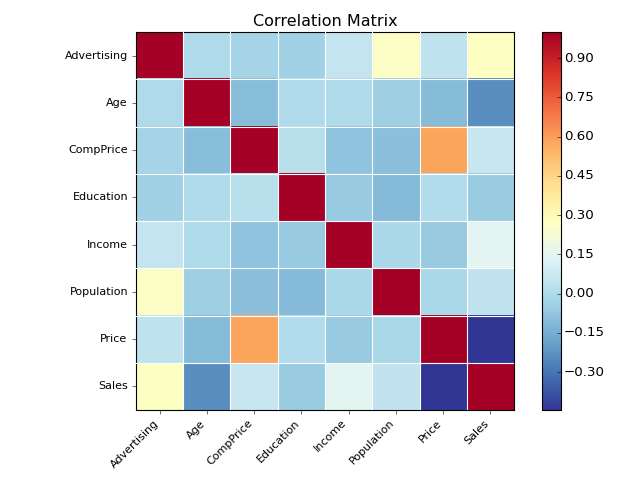

In [104]:
data = pd.read_csv(carseats_data_file,index_col=0)
data.head()
corr_matrix = np.corrcoef(data[data.columns.difference(['ShelveLoc','Urban','US'])].dropna(),rowvar=0)
f=sm.graphics.plot_corr(corr_matrix,xnames=list(data[data.columns.difference(['ShelveLoc','Urban','US'])]))

In [90]:
formula = 'Sales ~ Price + Urban + US'
y,x = dmatrices(formula,data=data,return_type='dataframe')
model = sm.OLS(endog=y,exog=x)
result = model.fit() 
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     41.52
Date:                Sat, 27 Feb 2016   Prob (F-statistic):           2.39e-23
Time:                        14:13:57   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1863.
Df Residuals:                     396   BIC:                             1879.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept       13.0435      0.651     20.036      0.000        11.764    14.323
Urban[T.Yes]    -0.0219      0.272     -0.081      0.936        -0.556     0.512
US[T.Yes]        1.2006      0.259      4.635      0.000         0.691     1.710
Price           -0.0545      0.005    -10.389      0.000        -0.065    -0.044
==============================================================================
Omnibus:                        0.676   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.713   Jarque-Bera (JB):                0.758
Skew:                           0.093   Prob(JB):                        0.684
Kurtosis:                       2.897   Cond. No.                         628.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 10.e) On the basis of your response to the previous question, fit a smaller model that only uses the predictors for which there is evidence of association with the outcome.
- Sales ~ Price + US
### 10.f) How well do the models in (a) and (e) fit the data?
- Look at residuals
### 10.g) Using the model from (e), obtain 95% confidence intervals for the coefficient(s).
- to be calculated
### 10.h) Is there evidence of outliers or high leverage observations in the model from (e)?
- Yes, samples 166 and 175, at least

In [109]:
formula = 'Sales ~ Price + US'
y,x = dmatrices(formula,data=data,return_type='dataframe')
model = sm.OLS(endog=y,exog=x)
result = model.fit() 
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     62.43
Date:                Sat, 27 Feb 2016   Prob (F-statistic):           2.66e-24
Time:                        15:38:23   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1861.
Df Residuals:                     397   BIC:                             1873.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     13.0308      0.631     20.652      0.000        11.790    14.271
US[T.Yes]      1.1996      0.258      4.641      0.000         0.692     1.708
Price         -0.0545      0.005    -10.416      0.000        -0.065    -0.044
==============================================================================
Omnibus:                        0.666   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.717   Jarque-Bera (JB):                0.749
Skew:                           0.092   Prob(JB):                        0.688
Kurtosis:                       2.895   Cond. No.                         607.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>


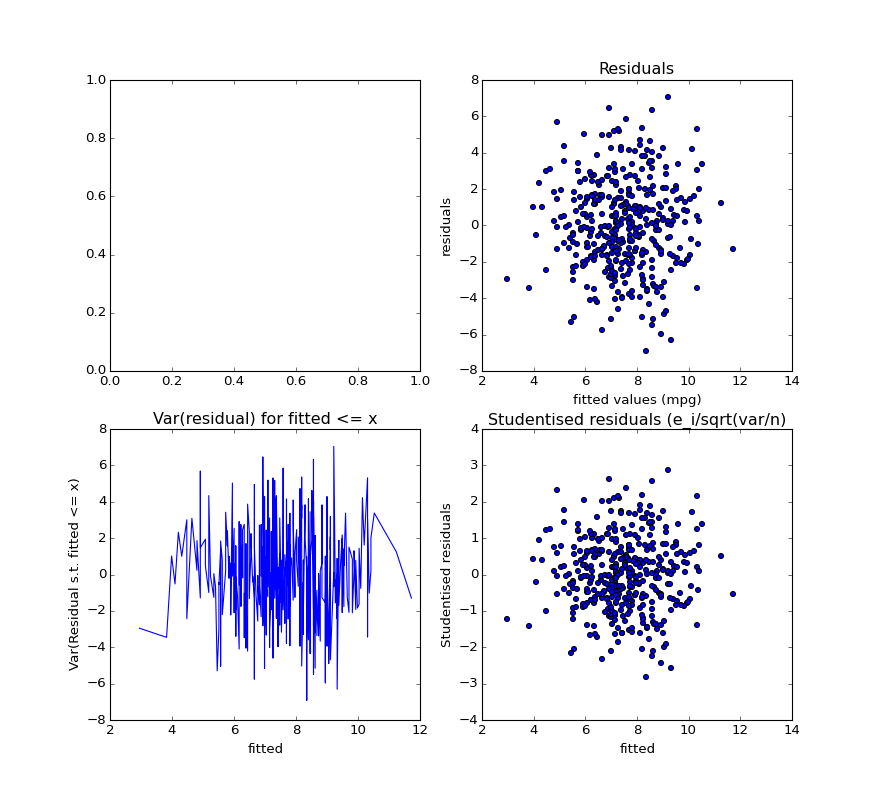

<IPython.core.display.Javascript object>


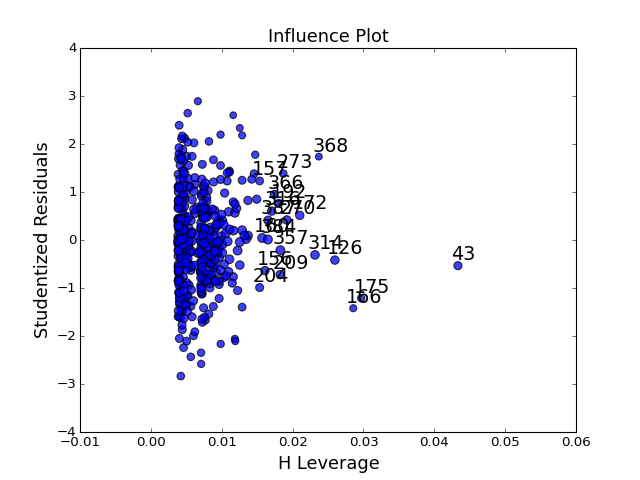

In [110]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(11,10,forward=True)

# (1) mpg vs. horsepower

# (2) RESIDUALS
ax[0,1].scatter(result.fittedvalues,result.resid)
ax[0,1].set_xlabel('fitted values (mpg)')
ax[0,1].set_ylabel('residuals')
ax[0,1].set_title('Residuals')
ax[0,1].text(0,25,'Var=%3.2f' % (np.var(result.resid)))

# (3) CUMULATIVE VARIANCE AS A FUNCTION OF LSTAT
residuals=pd.DataFrame({'fitted':result.fittedvalues,'resid':result.resid})
residuals_sort=residuals.sort(columns='fitted')
residuals_sort.reset_index(inplace=True)
residuals_sort['var_incr'] = np.nan
for i in residuals_sort.index:
    residuals_sort.loc[i,'var_incr'] = np.var(residuals_sort.iloc[0:i]['resid'])
ax[1,0].plot(residuals_sort['fitted'],residuals_sort['resid'])
ax[1,0].set_xlabel('fitted')
ax[1,0].set_ylabel('Var(Residual s.t. fitted <= x)')
ax[1,0].set_title('Var(residual) for fitted <= x')

# (4) Outliers, STUDENTIZED RESIDUALS 
# e_i / STD_ERR <-- e_i / sqrt(var/n)
# 
residuals['studentised']=result.get_influence().get_resid_studentized_external()
ax[1,1].scatter(residuals['fitted'],residuals['studentised'])
ax[1,1].set_xlabel('fitted')
ax[1,1].set_ylabel('Studentised residuals')
ax[1,1].set_title('Studentised residuals (e_i/sqrt(var/n)')

##### COMMENTS
# Residuals have a U-shape - that indicates non linearities in the relationship mpg/horsepower.
# Reflected in the other graphs. E.g. variance is non constant.
# There are some outliers in the data (bottom-right graph, STUD_RESID > 3). We should look for
#     high leverage points and see if they may cause a problem

# High Leverage, STUDENTISED RESIDUALS VS. LEVERAGE
p=sm.graphics.influence_plot(result,size=6,alpha=1)
infl = result.get_influence()
response = infl.summary_frame()

## As expected the cars with high leverage seem to be the same

## Ex 11. Simple linear regression without an intercept

- See below. Prediction WITH intercept is more accurate

In [127]:
np.random.seed(1)
data = pd.DataFrame({'x':np.random.rand(100),'y':2*x + np.random.rand(100)})

P-Values WITH NO intercept
x    1.500421e-60
dtype: float64
----------------------------
P-Values WITH intercept
Intercept    1.727409e-12
x            3.494893e-33
dtype: float64


<IPython.core.display.Javascript object>


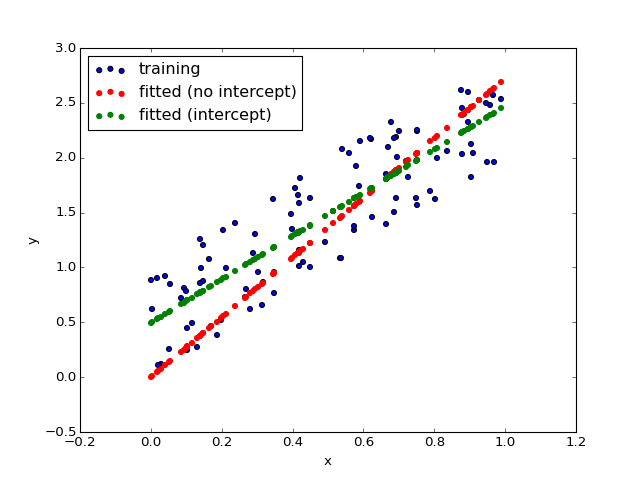

In [142]:
ym,xm = dmatrices('y ~ x - 1',data=data,return_type='dataframe')
model_no_int = sm.OLS(endog=ym,exog=xm)
result_no_int = model_no_int.fit() 

ym,xm = dmatrices('y ~ x',data=data,return_type='dataframe')
model_int = sm.OLS(endog=ym,exog=xm)
result_int = model_int.fit() 

print 'P-Values WITH NO intercept'
print result_no_int.pvalues
print '----------------------------'
print 'P-Values WITH intercept'
print result_int.pvalues

plt.figure()
plt.scatter(data['x'],data['y'],label='training')
plt.scatter(data['x'].dropna(),result_no_int.fittedvalues,color='r',label='fitted (no intercept)')
plt.scatter(data['x'].dropna(),result_int.fittedvalues,color='g',label='fitted (intercept)')

plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc=2)

## Ex 11 (second part) to 14: skipped

## Ex 15. Boston dataset

### 15.a) For each predictor, fit a simple linear regression model
- Null-hypothesis not rejected for CHAS

### 15.b) Fit a multiple regression model
- Null hypothesis not rejected for BLACK, DIS, INDUS, MEDV, RAD, ZN

In [253]:
data = sm.datasets.get_rdataset("Boston", "MASS").data

In [156]:
print 'SIMPLE LINEAR REGRESSION FOR ALL VARIABLES'
for pr in data.columns.difference(['crim']):
    formula = 'crim ~ ' + pr
    y,x = dmatrices(formula,data=data,return_type='dataframe')
    res = sm.OLS(endog=y,exog=x).fit()
    
    print 'P-Values ('+pr+'): [%2.16f,%2.16f]' % (res.pvalues[0],res.pvalues[1])
    
print 'MULTIPLE LINEAR REGRESSION'
formula = 'crim ~ ' + ' + '.join(data.columns.difference(['crim','chas']))
y,x = dmatrices(formula,data=data,return_type='dataframe')
res = sm.OLS(endog=y,exog=x).fit()
res.summary()

SIMPLE LINEAR REGRESSION FOR ALL VARIABLES
P-Values (age): [0.0000722171778224,0.0000000000000003]
P-Values (black): [0.0000000000000000,0.0000000000000000]
P-Values (chas): [0.0000000000000000,0.2094345015351991]
P-Values (dis): [0.0000000000000000,0.0000000000000000]
P-Values (indus): [0.0020912655160400,0.0000000000000000]
P-Values (lstat): [0.0000020870217738,0.0000000000000000]
P-Values (medv): [0.0000000000000000,0.0000000000000000]
P-Values (nox): [0.0000000000000051,0.0000000000000000]
P-Values (ptratio): [0.0000000339525491,0.0000000000294292]
P-Values (rad): [0.0000003605846164,0.0000000000000000]
P-Values (rm): [0.0000000022719998,0.0000006346702985]
P-Values (tax): [0.0000000000000000,0.0000000000000000]
P-Values (zn): [0.0000000000000000,0.0000055064721077]
MULTIPLE LINEAR REGRESSION


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   crim   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     34.10
Date:                Sat, 27 Feb 2016   Prob (F-statistic):           3.19e-57
Time:                        16:15:05   Log-Likelihood:                -1653.5
No. Observations:                 506   AIC:                             3333.
Df Residuals:                     493   BIC:                             3388.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     17.1260      7.229      2.369      0.018         2.922    31.330
age            0.0009      0.018      0.049      0.961        -0.034     0.036
black         -0.0076      0.004     -2.074      0.039        -0.015    -0.000
dis           -0.9933      0.281     -3.529      0.000        -1.546    -0.440
indus         -0.0692      0.083     -0.834      0.404        -0.232     0.094
lstat          0.1260      0.076      1.666      0.096        -0.023     0.275
medv          -0.2045      0.060     -3.417      0.001        -0.322    -0.087
nox          -10.5274      5.262     -2.001      0.046       -20.865    -0.190
ptratio       -0.2660      0.186     -1.429      0.154        -0.632     0.100
rad            0.5843      0.088      6.656      0.000         0.412     0.757
rm             0.4400      0.612      0.719      0.473        -0.763     1.643
tax           -0.0035      0.005     -0.675      0.500        -0.014     0.007
zn             0.0450      0.019      2.402      0.017         0.008     0.082
==============================================================================
Omnibus:                      666.208   Durbin-Watson:                   1.519
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            84644.335
Skew:                           6.610   Prob(JB):                         0.00
Kurtosis:                      64.968   Cond. No.                     1.58e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.58e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [233]:
formula = 'crim ~ ' + ' + '.join(data.columns.difference(['crim','chas','age','tax','rm','ptratio','nox','lstat']))
y,x = dmatrices(formula,data=data,return_type='dataframe')
res = sm.OLS(endog=y,exog=x).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   crim   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     66.38
Date:                Sat, 27 Feb 2016   Prob (F-statistic):           1.65e-60
Time:                        16:53:24   Log-Likelihood:                -1657.9
No. Observations:                 506   AIC:                             3330.
Df Residuals:                     499   BIC:                             3359.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     10.8150      2.275      4.755      0.000         6.346    15.284
black         -0.0084      0.004     -2.329      0.020        -0.015    -0.001
dis           -0.9046      0.232     -3.893      0.000        -1.361    -0.448
indus         -0.1418      0.070     -2.033      0.043        -0.279    -0.005
medv          -0.2008      0.038     -5.219      0.000        -0.276    -0.125
rad            0.4982      0.044     11.358      0.000         0.412     0.584
zn             0.0504      0.017      2.915      0.004         0.016     0.084
==============================================================================
Omnibus:                      662.225   Durbin-Watson:                   1.458
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            81980.240
Skew:                           6.547   Prob(JB):                         0.00
Kurtosis:                      63.967   Cond. No.                     2.93e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 15.c) How do your results from (a) compare to your results from (b)?
- Coefficient for nox changes dramatically. That may be because NOX is correlation with other variables (null hypothesis was not rejected earlier

### 15.d) Is there evidence of non-linear association between any of the predictors and the response?
- Yes for dis, indus, medv

<IPython.core.display.Javascript object>


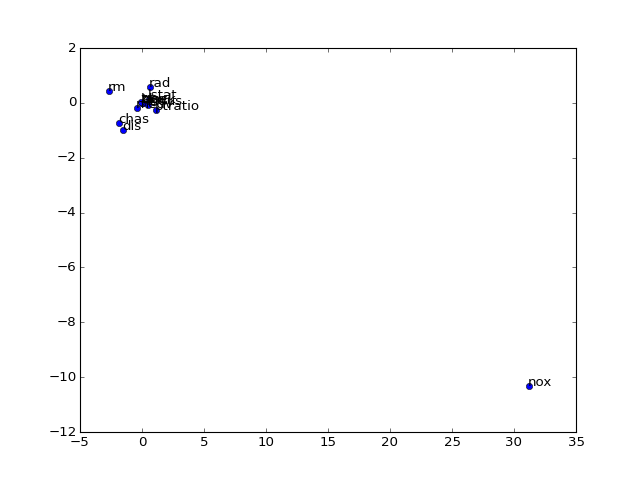

In [249]:
linear = {}
multiple = {}

for pr in data.columns.difference(['crim']):
    formula = 'crim ~ ' + pr
    y,x = dmatrices(formula,data=data,return_type='dataframe')
    res = sm.OLS(endog=y,exog=x).fit()
    linear[pr] = res.params[1]

formula = 'crim ~ ' + ' + '.join(data.columns.difference(['crim']))
y,x = dmatrices(formula,data=data,return_type='dataframe')
res = sm.OLS(endog=y,exog=x).fit()
for l in res.params.index - ['Intercept']:
    multiple[l] = res.params[l]

xx=pd.DataFrame([linear,multiple],index=['linear','multiple']).T
plt.figure()
plt.plot(xx['linear'],xx['multiple'],'o')
for i in xx.index:
    plt.annotate(s=i,xy=(xx.loc[i][0],xx.loc[i][1]))

<IPython.core.display.Javascript object>


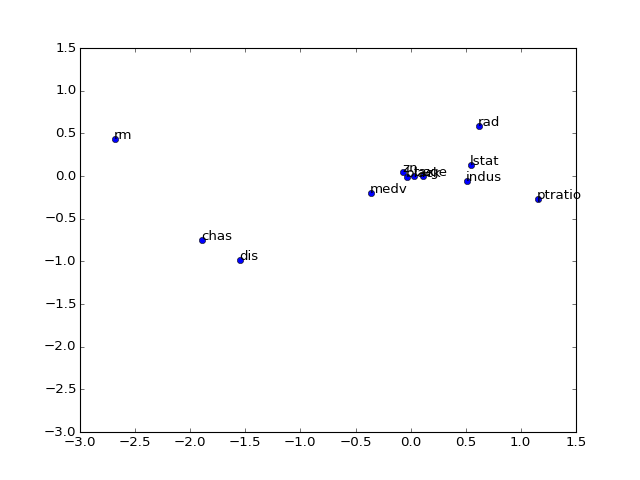

In [250]:
linear.pop('nox')
multiple.pop('nox')
xx=pd.DataFrame([linear,multiple],index=['linear','multiple']).T
plt.figure()
plt.plot(xx['linear'],xx['multiple'],'o')
plt.xlim([-3, 1.5])
plt.ylim([-3, 1.5])

for i in xx.index:
    plt.annotate(s=i,xy=(xx.loc[i][0],xx.loc[i][1]))

In [254]:
print 'SIMPLE LINEAR REGRESSION FOR ALL VARIABLES'
for pr in ['black','dis','indus','medv','rad','zn']:
    formula = 'crim ~ ' + pr + ' + np.power('+pr+',2) + np.power('+pr+',3)'
    y,x = dmatrices(formula,data=data,return_type='dataframe')
    res = sm.OLS(endog=y,exog=x).fit()
    
    print 'P-Values ('+pr+'): [%2.16f , %2.16f , %2.16f , %2.16f]' % (res.pvalues[0],res.pvalues[1],res.pvalues[2],res.pvalues[3])
    

SIMPLE LINEAR REGRESSION FOR ALL VARIABLES
P-Values (black): [0.0000000000000150 , 0.1385871340438594 , 0.4741750826116301 , 0.5436171817156397]
P-Values (dis): [0.0000000000000000 , 0.0000000000000000 , 0.0000000000049412 , 0.0000000108883203]
P-Values (indus): [0.0203652597124644 , 0.0000529706368013 , 0.0000000003420187 , 0.0000000000011964]
P-Values (medv): [0.0000000000000000 , 0.0000000000000000 , 0.0000000000000000 , 0.0000000000010465]
P-Values (rad): [0.7678317206241246 , 0.6234175211532458 , 0.6130098773159266 , 0.4823137740356493]
P-Values (zn): [0.0000000000000000 , 0.0026122963084963 , 0.0937504996020975 , 0.2295386204908472]
